# EP2 - MAC0425 (Inteligência Artificial) : Previsão de Estágio da Infecção por COVID-19 - Dados do HC

João Pedro Barioni Agostini  
Nathália Yukimi Uchiyama Tsuno

# 4. Construção da Arquitetura de Redes Neurais

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

## 4.1. Aplicação de normalização e PCA para melhorar o desempenho

Aplicamos a normalização de dados, evitando distorções no espaço vetorial dos dados. Assim, permitimos uma separação melhor das classes.

Posteriormente, aplicamos o algoritmo de PCA para reduzir a dimensionalidade do domínio do problema. Com 90% dos dados, obtemos 9 componentes principais que concentram esses dados todos.

Finalmente, splitamos esses dados entre o conjunto de treinamento e de teste, na proporção 20/80.

In [2]:
df_filtrado = pd.read_csv('dados_filtrados.csv')

# Separando dados em features (x) e target (y)
y_df = df_filtrado['COVID-19 - PESQUISA DE ANTICORPOS IgG / COVID-19 IgG \ de_resultado']
x_df = df_filtrado.drop(columns=['COVID-19 - PESQUISA DE ANTICORPOS IgG / COVID-19 IgG \ de_resultado'])

# Certifique-se de que x_df e y_df tenham o mesmo tamanho!
print("Tamanho de x_df:", len(x_df))
print("Tamanho de y_df:", len(y_df))

# Remova linhas com y_df = 0.5 (apenas 0.3% dos dados)
mask = y_df.isin([0.0, 1.0])
x_df = x_df[mask]
y_df = y_df[mask]

# Verificar distribuição das classes
print("\nDistribuição das classes após remoção de 0.5:\n", y_df.value_counts(normalize=True))

# Escalonamento/ Normalização dos dados
scaler = StandardScaler()
x_df_scaled = scaler.fit_transform(x_df)
x_df_scaled = pd.DataFrame(x_df_scaled, columns=x_df.columns)

# Aplicação do PCA para garantir apenas atributos interessantes e redução de dimensionalidade
porcentagem = 0.95 # Retém 90% da variância
pca = PCA(n_components=porcentagem)
X_pca = pca.fit_transform(x_df_scaled)
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]) # Transformando de volta num dataframe

# Visualização do PCA
print(f'Impressão da tabela de PCA')
display(df_pca)

# Split inicial (treino + teste)
X_train, X_test, y_train, y_test = train_test_split(
  df_pca, y_df, test_size=0.2, random_state=256, stratify=y_df
)

# Converter para DataFrames
X_train_scaled_df = pd.DataFrame(X_train, columns=df_pca.columns)
X_test_scaled_df = pd.DataFrame(X_test, columns=df_pca.columns)

Tamanho de x_df: 2807
Tamanho de y_df: 2807

Distribuição das classes após remoção de 0.5:
 COVID-19 - PESQUISA DE ANTICORPOS IgG / COVID-19 IgG \ de_resultado
0.0    0.873481
1.0    0.126519
Name: proportion, dtype: float64
Impressão da tabela de PCA


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.539522,1.053598,-0.412034,0.747443,1.044072,0.511277,0.247438,-1.259533,-0.799710,-0.091718,-0.531894,0.113694,0.829940,0.116272,0.536417,-0.525073,0.679095,0.503264,-0.274605,-0.111407
1,1.053628,-0.078457,0.429859,0.033028,-0.254569,-0.569401,0.114992,-0.295929,-0.995134,0.051897,-0.445441,0.468437,1.464252,0.102622,-1.674375,-0.744087,0.061964,-0.441680,-0.644668,0.113936
2,0.266123,-0.701327,-0.226396,-0.029961,-0.120963,-0.446020,-0.385204,0.165206,-0.917205,-0.187702,-0.354238,0.070741,1.960430,-1.024190,-1.047163,-0.367774,0.023820,0.819461,-1.194873,0.524390
3,0.043867,1.017513,0.372388,0.844489,0.899889,0.386546,-0.004242,-1.204032,-0.647573,-0.226311,-0.558340,0.200114,0.969735,-0.063475,-0.446034,-0.047680,-0.326838,1.479833,0.051666,0.578452
4,0.405536,-0.257213,-0.404764,0.090405,-0.812429,-1.379615,2.597157,-0.421433,-2.924108,-1.042296,1.845108,-0.745668,0.484287,-0.732337,-0.848572,-0.362405,0.801252,0.092573,0.477685,0.061961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,0.891072,1.176044,0.590642,0.464116,-0.338138,0.418886,2.692841,1.664401,0.154973,-0.743093,1.936202,-0.928808,-1.081423,-0.431239,1.144455,-0.109725,1.458823,1.044214,1.345367,1.264110
2794,-1.004602,0.047928,-0.228204,-1.820804,-0.650241,-0.725269,-0.093963,0.088681,1.378832,-0.035257,0.088331,-0.176892,-1.235796,0.132069,0.425455,0.215096,-0.369209,0.171331,-0.707330,0.125191
2795,0.888914,0.259228,0.559203,1.538899,-0.745166,-0.628819,-0.463729,1.157764,0.543348,-0.054866,0.264912,-0.699724,-0.847670,0.406525,-0.304413,0.051512,-0.108482,-0.853759,-0.723305,0.466278
2796,0.712663,-0.975646,-0.140497,0.596532,-0.509374,1.323469,-0.431206,-0.577395,1.298135,-0.250422,0.706733,-0.821775,-1.343314,1.197689,0.105833,-0.475629,0.373231,1.092796,0.263905,-0.670544


## 4.2. Definir Dataset e Modelo

Nossa rede possui duas hidden layers, cada uma contendo 256 perceptrons cada. Aplicamos a Leaky ReLU como função de ativação, para dar uma não-linearidade aos dados.

Nosso modelo, portanto, possui a seguinte arquitetura (256, 256)

In [3]:
class CovidDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class CovidPredictor(nn.Module):
    def __init__(self, input_dim):
        super(CovidPredictor, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 256)
        self.dropout = nn.Dropout(0.3)
        self.layer_2 = nn.Linear(256, 256)
        self.layer_out = nn.Linear(256, 1)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return x

## 4.3. Configuração de Treino

Na configuração de treinamento do modelo, usamos validação cruzada (com k-folds) sobre os dados de treinamento. Com k = 5.

Rodamos com 100 épocas, usando o Descendente Gradiente no backpropagation, para atualização dos dados com taxa de aprendizagem de 0.01 (não tão grande para convergir rapidamente, nem tão pequeno para não demorar muito tempo para aprender corretamente os pesos)

Finalmente, intitulamos um limiar de 0.3

In [4]:
threshold = 0.3

In [5]:
def train_model(X_train, y_train, X_val, y_val):
    train_dataset = CovidDataset(X_train, y_train)
    val_dataset = CovidDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_dim = X_train.shape[1]
    model = CovidPredictor(input_dim)

    pos_weight = torch.tensor([0.875 / 0.125])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    epochs = 100
    best_f1 = 0
    best_recall = 0
    best_precision = 0
    best_accuracy = 0
    best_confusion_matrix = None

    # Listas para armazenar as perdas
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = torch.sigmoid(outputs)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Armazena as losses por época
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Ajuste de threshold para priorizar recall
        #threshold = 0.5  # <- Certifique-se de definir um threshold
        y_pred = (np.array(all_preds) > threshold).astype(int)
        f1 = f1_score(all_labels, y_pred)
        auc = roc_auc_score(all_labels, all_preds)
        recall = recall_score(all_labels, y_pred)
        precision = precision_score(all_labels, y_pred)
        accuracy = accuracy_score(all_labels, y_pred)

        print(f"Época {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Val F1: {f1:.4f}, Val AUC: {auc:.4f}")
        print(confusion_matrix(all_labels, y_pred), "\n")

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_precision = precision
            best_accuracy = accuracy
            best_confusion_matrix = confusion_matrix(all_labels, y_pred)
            torch.save(model.state_dict(), "best_model.pt")

    return best_f1, train_losses, val_losses, best_recall, best_precision, best_accuracy, best_confusion_matrix

## 4.4. Cross-Validation Estratificado

In [6]:
# --- 4. Cross-Validation Estratificado ---
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=256)
f1_scores = []

# Para experimentos:
train_losses = []
validation_losses = []
acc = []
recall = []
precision = []
confusion = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled_df, y_train)):
    print(f"\n--- Fold {fold+1}/{k} ---")
    X_train_fold, X_val_fold = X_train_scaled_df.iloc[train_index], X_train_scaled_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    best_f1, train_loss, validation_loss, best_recall, best_precision, best_accuracy, best_confusion_matrix = train_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    f1_scores.append(best_f1)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    acc.append(best_accuracy)
    recall.append(best_recall)
    precision.append(best_precision)
    confusion.append(best_confusion_matrix)

print(f"\nF1-Scores por fold: {f1_scores}")
print(f"Média F1-Score: {np.mean(f1_scores):.4f}")


--- Fold 1/5 ---
Época 1/100
Train Loss: 1.1016, Val Loss: 0.9432
Val F1: 0.2275, Val AUC: 0.9665
[[  4 387]
 [  0  57]] 

Época 2/100
Train Loss: 0.8228, Val Loss: 0.6796
Val F1: 0.2441, Val AUC: 0.9769
[[ 38 353]
 [  0  57]] 

Época 3/100
Train Loss: 0.5865, Val Loss: 0.4959
Val F1: 0.5258, Val AUC: 0.9882
[[291 100]
 [  1  56]] 

Época 4/100
Train Loss: 0.4205, Val Loss: 0.3977
Val F1: 0.8244, Val AUC: 0.9923
[[371  20]
 [  3  54]] 

Época 5/100
Train Loss: 0.3509, Val Loss: 0.3405
Val F1: 0.8833, Val AUC: 0.9934
[[381  10]
 [  4  53]] 

Época 6/100
Train Loss: 0.3041, Val Loss: 0.3091
Val F1: 0.9217, Val AUC: 0.9938
[[386   5]
 [  4  53]] 

Época 7/100
Train Loss: 0.2580, Val Loss: 0.2889
Val F1: 0.9204, Val AUC: 0.9945
[[387   4]
 [  5  52]] 

Época 8/100
Train Loss: 0.2159, Val Loss: 0.2723
Val F1: 0.9369, Val AUC: 0.9951
[[389   2]
 [  5  52]] 

Época 9/100
Train Loss: 0.2123, Val Loss: 0.2527
Val F1: 0.9464, Val AUC: 0.9961
[[389   2]
 [  4  53]] 

Época 10/100
Train Loss: 0.1

## 4.5 Avaliação no Teste


--- Métricas no Teste ---
F1-Score: 0.9714
AUC: 0.9999
Recall: 0.9577
Precision: 0.9855


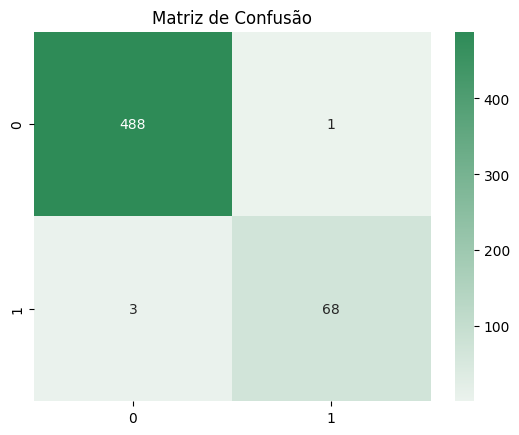

In [7]:
# --- 5. Avaliação no Teste ---
test_dataset = CovidDataset(X_test_scaled_df, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = CovidPredictor(X_train_scaled_df.shape[1])
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_pred_test = (np.array(all_preds) > threshold).astype(int)

print("\n--- Métricas no Teste ---")
print(f"F1-Score: {f1_score(all_labels, y_pred_test):.4f}")
print(f"AUC: {roc_auc_score(all_labels, all_preds):.4f}")
print(f'Recall: {recall_score(all_labels, y_pred_test):.4f}')
print(f'Precision: {precision_score(all_labels, y_pred_test):.4f}')

sns.heatmap(confusion_matrix(all_labels, y_pred_test), annot=True, fmt="d", cmap=sns.light_palette("seagreen", as_cmap=True))
plt.title("Matriz de Confusão")
plt.show()

Como resultado, nosso modelo teve uma ótima acurácia, com ótima revocação, precisão e, consequentemente, F1.

## 4.6. Experimentos

In [8]:
def Plot(train_losses, val_losses, fold):
  plt.figure(figsize=(10, 6))
  plt.plot(train_losses, label="Train Loss", marker='*', color="seagreen")
  plt.plot(val_losses, label="Validation Loss", marker='o', color="palegreen")
  plt.xlabel("Época")
  plt.ylabel("Loss")
  plt.title(f"Perda de Treinamento e Validação por Época, No Fold {fold + 1}")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

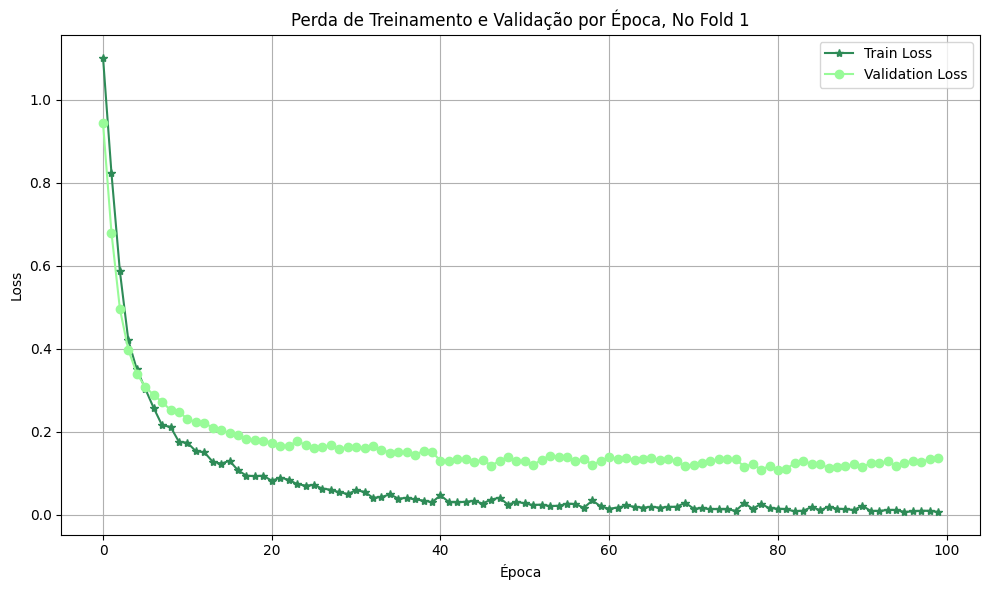

Acurácia no Fold 1: 0.9955
Revocação no Fold 1: 0.9649
Precisão no Fold 1: 1.0000
F1-Score no Fold 1: 0.9821


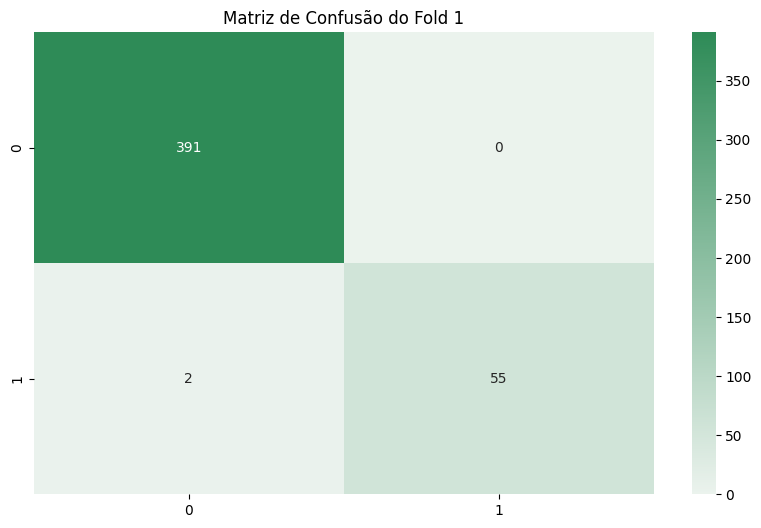

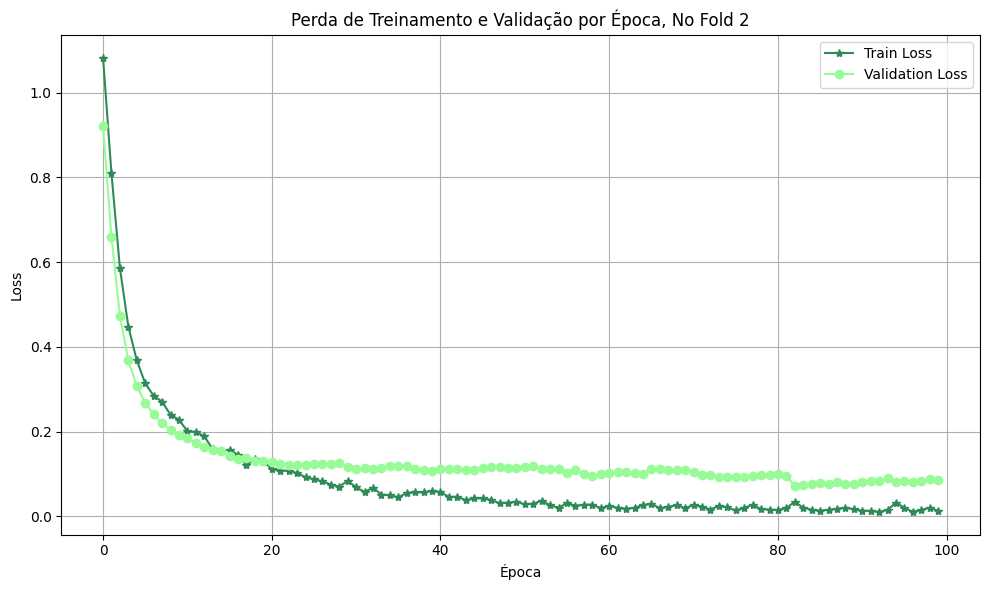

Acurácia no Fold 2: 0.9955
Revocação no Fold 2: 0.9825
Precisão no Fold 2: 0.9825
F1-Score no Fold 2: 0.9825


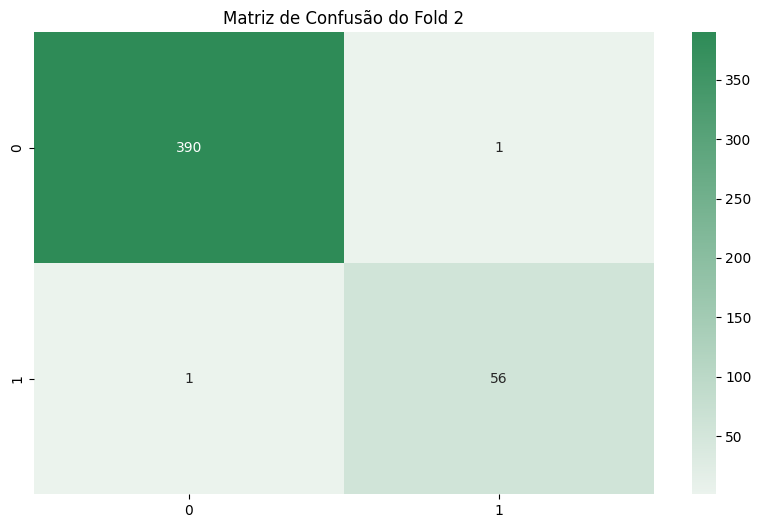

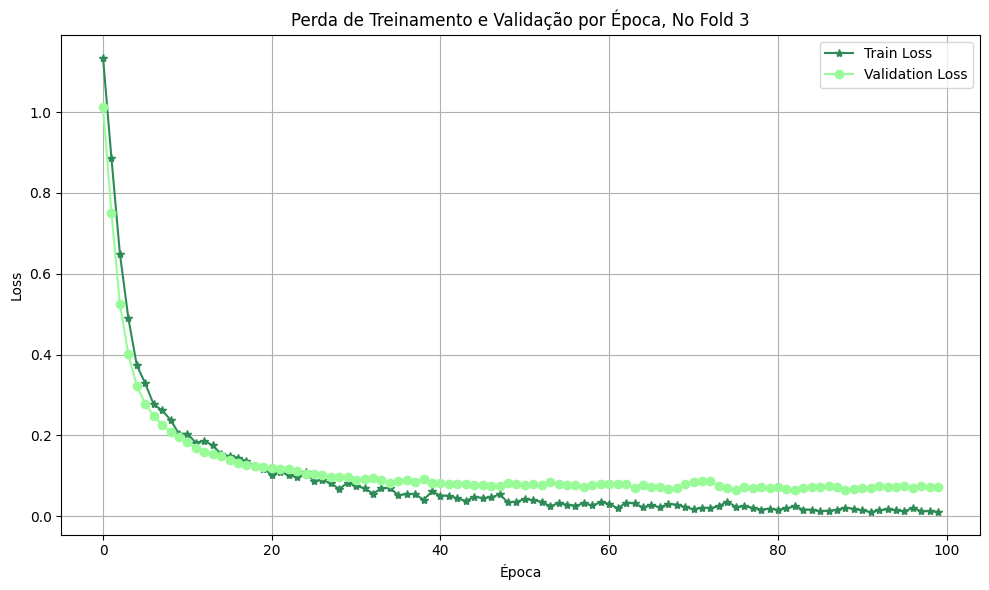

Acurácia no Fold 3: 0.9978
Revocação no Fold 3: 0.9825
Precisão no Fold 3: 1.0000
F1-Score no Fold 3: 0.9912


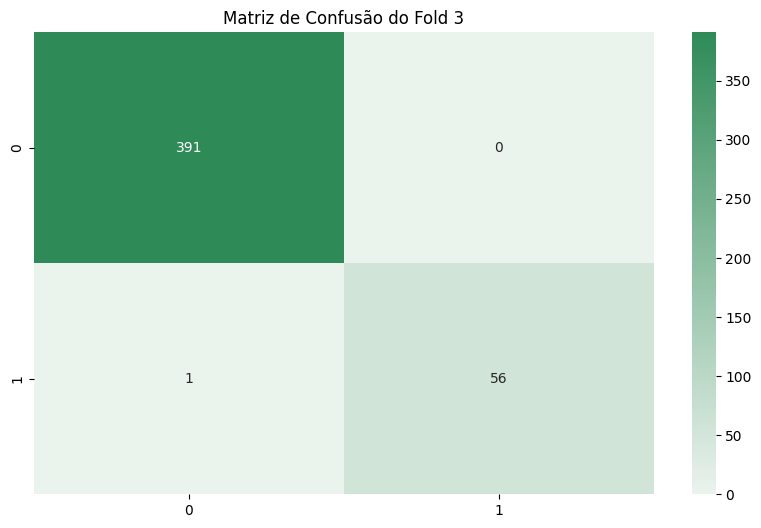

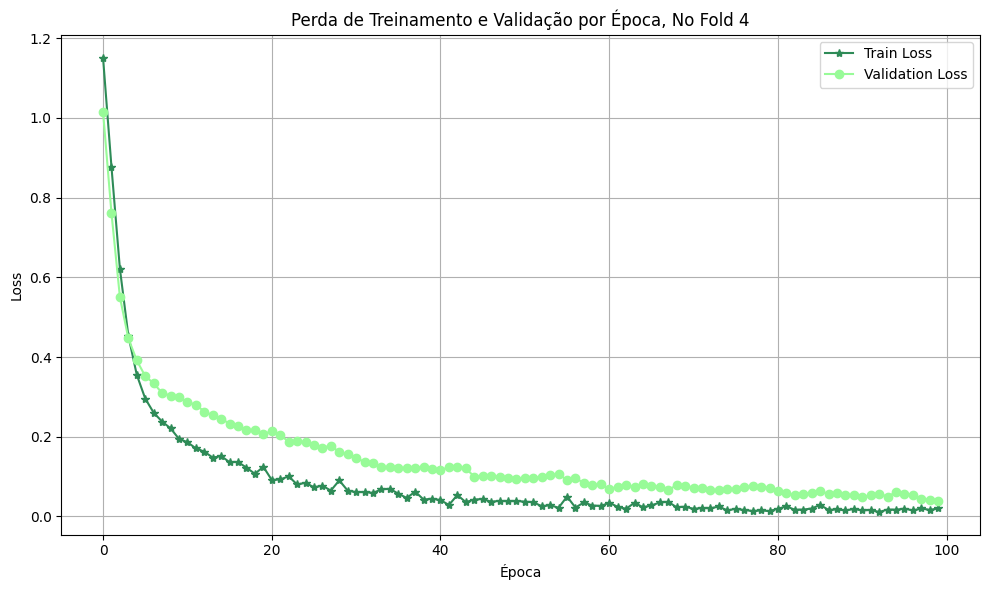

Acurácia no Fold 4: 1.0000
Revocação no Fold 4: 1.0000
Precisão no Fold 4: 1.0000
F1-Score no Fold 4: 1.0000


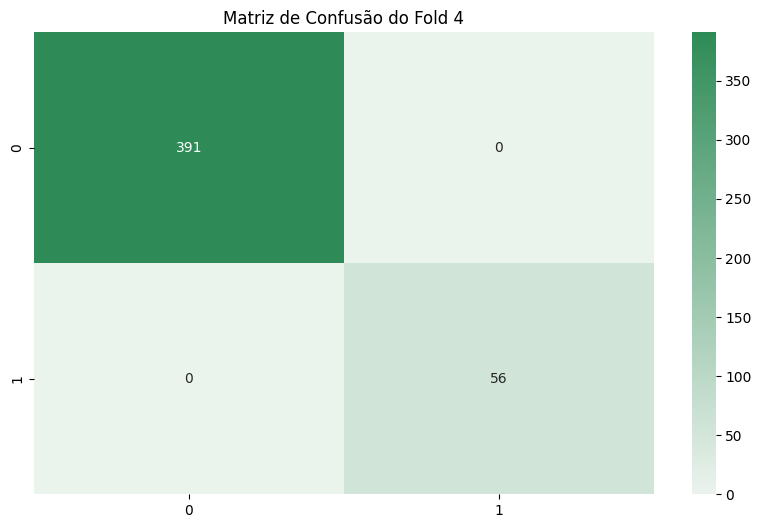

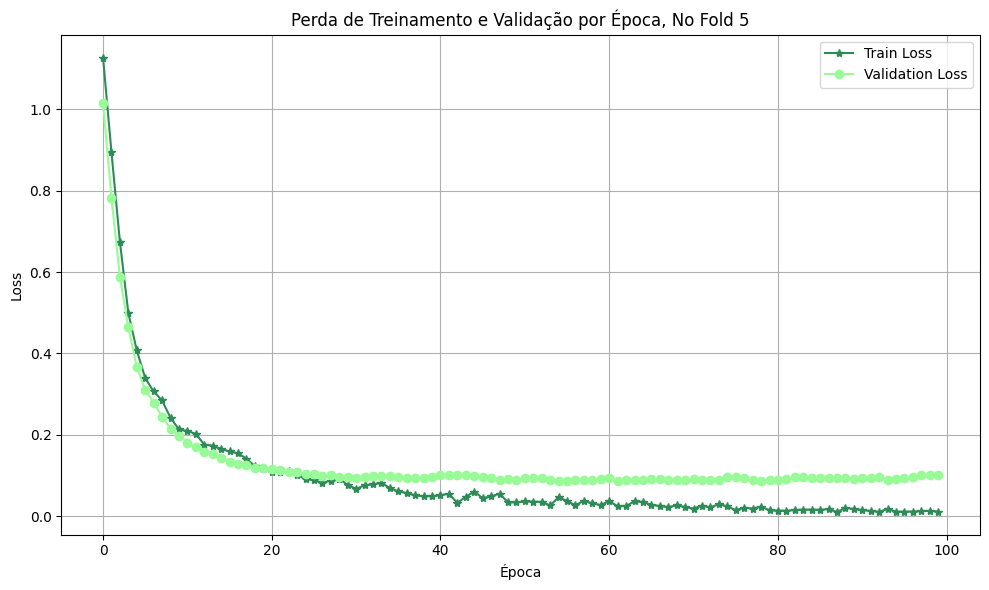

Acurácia no Fold 5: 0.9978
Revocação no Fold 5: 0.9821
Precisão no Fold 5: 1.0000
F1-Score no Fold 5: 0.9910


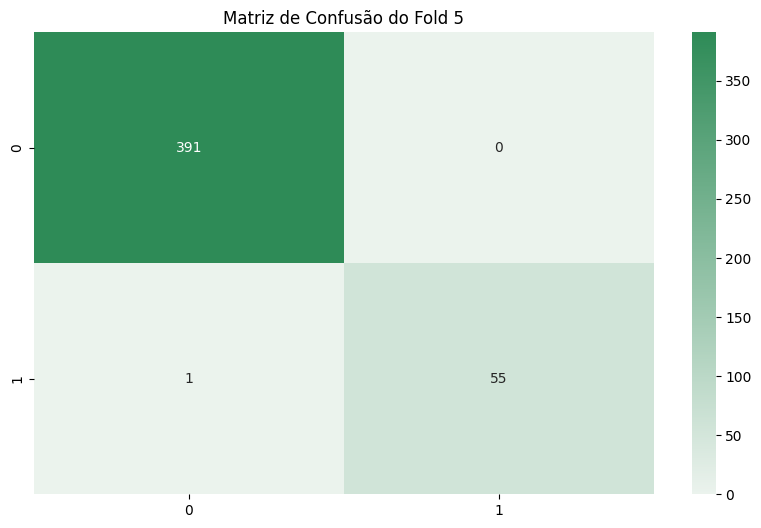

In [9]:
for i in range(len(train_losses)):
  Plot(train_losses[i], validation_losses[i], i)
  print(f'Acurácia no Fold {i + 1}: {acc[i]:.4f}')
  print(f'Revocação no Fold {i + 1}: {recall[i]:.4f}')
  print(f'Precisão no Fold {i + 1}: {precision[i]:.4f}')
  print(f'F1-Score no Fold {i + 1}: {f1_scores[i]:.4f}')
  plt.figure(figsize=(10, 6))
  sns.heatmap(confusion[i], annot=True, fmt="d", cmap=sns.light_palette("seagreen", as_cmap=True))
  plt.title(f"Matriz de Confusão do Fold {i + 1}")
  plt.show()


In [10]:
np_acc = np.array(acc)
np_recall = np.array(recall)
np_precision = np.array(precision)
np_f1 = np.array(f1_scores)

metricas = [np_acc, np_recall, np_precision, np_f1]

for i in metricas:
  print(f'Média : {i.mean()}')
  print(f'Desvio Padrão : {i.std()}')
  print(f'Maior Valor : {i.max()}')
  print(f'Menor Valor : {i.min()}')
  print()

Média : 0.9973204298497922
Desvio Padrão : 0.0016701170154996507
Maior Valor : 1.0
Menor Valor : 0.9955357142857143

Média : 0.982393483709273
Desvio Padrão : 0.011096418700382395
Maior Valor : 1.0
Menor Valor : 0.9649122807017544

Média : 0.9964912280701753
Desvio Padrão : 0.007017543859649145
Maior Valor : 1.0
Menor Valor : 0.9824561403508771

Média : 0.9893480861925201
Desvio Padrão : 0.006615514118500983
Maior Valor : 1.0
Menor Valor : 0.9821428571428571

